# Uniform Linear Array

### Creation of the array
We consider an uniform linear array of $N_{ant}$ antenna. The system funciton for $fc = 2.4GHz$. The frequency sample of the system is $fs = 64.MHz$. A signal is emitted from a $T_x$ antenna at a certain position. The goal is to definite the direction of arrival of the $T_x$ signal. 

According to antialisaing, the space between antenna is defined to $\lambda/2$.\
Here, we work in the $XY$ plan. Differents DOA methods will be consider such as <u>beamforming</u>, <u>CAPON</u>, <u>MUSIC</u>. 

In [20]:
import numpy as np
import sys

sys.path.append('.././Library')
import TDS_perso
import matplotlib.pyplot as plt
from scipy.fft import ifftshift
from scipy.linalg import eig

In [2]:
# Constant 
CELERITY_LIGHT = 299792458

# Physical parameters
fc = 2.4e9
lambdaVal = CELERITY_LIGHT/fc

In [3]:
# systems variables Rx
fs_Rx = 20e6
Nech_Rx = 2**14
print("Parametres Rx : fs = ", fs_Rx/1e6, "MHz, Nech = ", Nech_Rx )

GainRx = 2
GainRxLin = 10**(GainRx/10) # Attention à mettre le gain en lineaire


Parametres Rx : fs =  20.0 MHz, Nech =  16384


In [4]:
# systems variables Tx
fs_Tx = 11.2e6 #(ex DJI)
Nech_Tx = 2**12
print("Parametres Tx : fs = ", fs_Tx/1e6, "MHz, Nech = ", Nech_Tx )

# parametres systemes
sigPowdBm = 18  #dBm
R         = 50 #charge de 50 ohm
sigPowLin = 10**((sigPowdBm-30)/10) # conversion en Watts

GainTx    = 2
GainTxLin = 10**(GainTx/10) # Attention à mettre le gain en lineaire


Parametres Tx : fs =  11.2 MHz, Nech =  4096


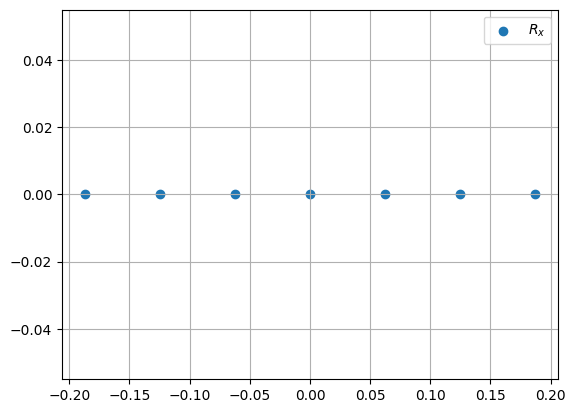

In [5]:
# define the ULA
N_ant = 7
dx = lambdaVal/2
x_pos_Rx = np.arange(0,N_ant, 1)[np.newaxis]*dx
x_pos_Rx = x_pos_Rx-np.mean(x_pos_Rx)
y_pos_Rx = np.zeros((1,N_ant))
pos_Rx = np.concatenate((x_pos_Rx,y_pos_Rx), axis = 0)


plt.figure()
plt.scatter(pos_Rx[0,:], pos_Rx[1,:], label="$R_x$")
plt.legend()
plt.grid()

the radial distance of the Tx from the center of the array is:
$$r = \sqrt{x_{Tx}^2+y_{Tx}^2} $$

The true doa value from the center of the array is :
$$ \theta = sin^{-1}\Biggl(\frac{x_{Tx}}{\sqrt{x_{Tx}^2+y_{Tx}^2}}\Biggl) $$

Nombre de Tx :  2
Radial distance of Tx from the center of the array  [58.30951895 80.62257748] m
Direction of arrival from the array : [-30.96375653   7.12501635] deg


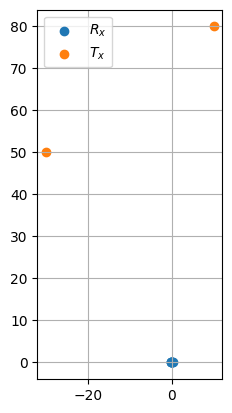

In [6]:
# define position of the Tx
x_pos_Tx = [[-30, 10]]
y_pos_Tx = [[50, 80]]
pos_Tx = np.concatenate((x_pos_Tx,y_pos_Tx), axis = 0)
n_Tx = len(pos_Tx[0,:])
print("Nombre de Tx : ", n_Tx)

# calculation of the radial distance
dist_from_origine = np.sqrt(pos_Tx[0,:]**2+pos_Tx[1,:]**2)
print("Radial distance of Tx from the center of the array ", dist_from_origine, "m")

# caluclation of the doa 
real_doa = np.asin(pos_Tx[0,:]/dist_from_origine)
print("Direction of arrival from the array :", np.rad2deg(real_doa), "deg")

plt.figure()
plt.scatter(pos_Rx[0,:], pos_Rx[1,:], label="$R_x$")
plt.scatter(pos_Tx[0,:], pos_Tx[1,:], label="$T_x$")
plt.legend()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.grid()

## Generation of a OFDM Signal
An ofdm signal is used 

In [7]:
# generation of a signal 
bandwidth = 10e6
NumberBloc = 4
signal, timeV, params, dataframe = TDS_perso.generationWIMAX(bandwidth, NumberBloc)
Nech = len(signal)

fs = :  11.2 MHz
Bloc Symbol duration : 102.9 micros


In [8]:
def champ_libre_mimo(tx_positions, rx_positions, freq):
    """
    Calcule la matrice de canal MIMO en champ libre avec atténuation et déphasage.
    
    Paramètres :
    - tx_positions : array (N_tx, 3) positions des antennes TX (x, y, z)
    - rx_positions : array (N_rx, 3) positions des antennes RX (x, y, z)
    - freq : fréquence en Hz
    
    Retour :
    - H : matrice MIMO complexe (N_rx x N_tx)
    - distances : matrice des distances (N_rx x N_tx)
    - retards : matrice des retards en secondes (N_rx x N_tx)
    """
    c = 3e8  # Vitesse de la lumière (m/s)
    wavelength = c / freq
    
    N_rx = rx_positions.shape[1]
    N_tx = tx_positions.shape[1]
    
    H = np.zeros((N_rx, N_tx), dtype=complex)
    distances = np.zeros((N_rx, N_tx))
    retards = np.zeros((N_rx, N_tx))
    
    for i in range(N_rx):
        for j in range(N_tx):
            d_ij = np.linalg.norm(rx_positions[:,i] - tx_positions[:,j])
            distances[i, j] = d_ij
            tau_ij = d_ij / c
            retards[i, j] = tau_ij
            
            attenuation = wavelength / (4 * np.pi * d_ij)
            phase = -2 * np.pi * freq * tau_ij
            H[i, j] = attenuation * np.exp(1j * phase)
    
    return H, distances, retards


In [9]:
# calculation of the freeloss space
H, distances, retards = champ_libre_mimo(pos_Tx, pos_Rx, fc)

signalPathLoss = np.zeros((len(signal), N_ant, n_Tx), dtype = "complex")
for ind in range(n_Tx):
    signal, timeV, params, dataframe = TDS_perso.generationWIMAX(bandwidth, NumberBloc)
    signalPathLoss[:,:,ind] = np.sqrt(sigPowLin*GainRxLin*GainTxLin)*signal*H[:,ind]

if n_Tx>1:
    signalPathLoss = np.sum(signalPathLoss, axis=2)
else:
    signalPathLoss = np.squeeze(signalPathLoss)

fs = :  11.2 MHz
Bloc Symbol duration : 102.9 micros
fs = :  11.2 MHz
Bloc Symbol duration : 102.9 micros


In [11]:
def compute_steering_vector(num_ant=8, angle_res=1, angle_rng=90):
    """ Computes array of Steering Vectors for a desired angluar range
        and resolution. **This is a special function that only computes the
        steering vectors along a 1D linear axis.**
        Inputs:
            angle_res - angle resolution in degrees
            angle_rng - single sided angle range
            num_ant - number of virtual antennas
        Output:
            steering_vectors
    """
    # get number of steering vectors based on desired angle range and resolution
    num_vec = (2 * angle_rng / angle_res + 1)
    num_vec = int(round(num_vec))

    # convert to radians
    angle_rng = angle_rng*np.pi/180
    angle_res = angle_res*np.pi/180
    # compute steering vectors
    steering_vectors = np.zeros((num_vec, num_ant), dtype=np.complex64)
    for k in range(num_vec):
        for m in range(num_ant):
            steering_vectors[k, m] = np.exp(-1j*np.pi*m
                                            *np.sin(-angle_rng + k*angle_res))
            
    return steering_vectors

In [12]:
thetaVect = np.arange(-90, 91,1)
steerVect = compute_steering_vector(num_ant=N_ant, angle_res=1, angle_rng=90)
print(steerVect.shape)

(181, 7)


N source : 2
True DOA : [-30.96375653   7.12501635]
estimation beam =  [-32]
estimation capon =  [-31]
estimation music =  [-31]


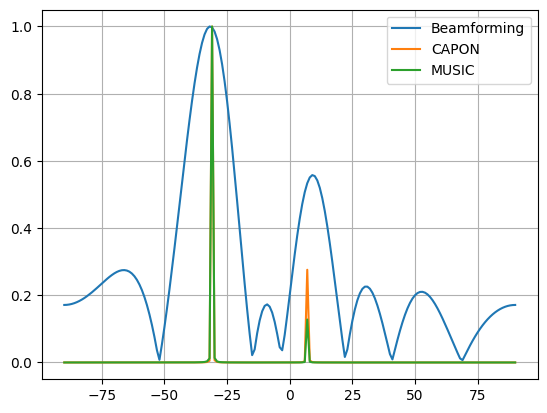

In [13]:
# simulation without noise
Rxx = np.dot(signalPathLoss.T.conj(), signalPathLoss)/Nech

# beamforming
beam = steerVect.conj()@Rxx@steerVect.T
beam = np.abs(np.sum(beam, axis=1))
beam = beam/np.max(beam) # normalisation

# CAPON
Rxx_inv = np.linalg.pinv(Rxx + 1e-16*np.eye(Rxx.shape[0]))
capon = np.zeros(len(thetaVect), dtype="complex")
for it in range(len(thetaVect)):
    capon[it] = 1/(steerVect[it,:].conj()@Rxx_inv@steerVect[it,:].T)
capon = np.abs(capon)
capon = capon/np.max(capon) # normalisation

# MUSIC
nsource = n_Tx
print("N source :", nsource)
eigVal, eigVect = np.linalg.eig(Rxx)
idx = np.argsort(eigVal)[::-1]
eigVect = eigVect[:, idx]
EE = eigVect[:, nsource:]@eigVect[:, nsource:].T.conj()
music = np.zeros(len(thetaVect), dtype="complex")
for it in range(len(thetaVect)):
    music[it] = 1/(steerVect[it,:].conj()@EE@steerVect[it,:].T)
music = np.abs(music)
music = music/np.max(music) # normalisation

# estimation doa
print("True DOA :", np.rad2deg(real_doa))

locBeam = np.where(beam==np.max(beam))
print("estimation beam = ", thetaVect[locBeam])

locCAPON = np.where(capon==np.max(capon))
print("estimation capon = ", thetaVect[locCAPON])

locMUSIC = np.where(music==np.max(music))
print("estimation music = ", thetaVect[locMUSIC])


plt.figure()
plt.plot(thetaVect, beam, label="Beamforming")
plt.plot(thetaVect, capon, label="CAPON")
plt.plot(thetaVect, music, label="MUSIC")

plt.grid()
plt.legend()


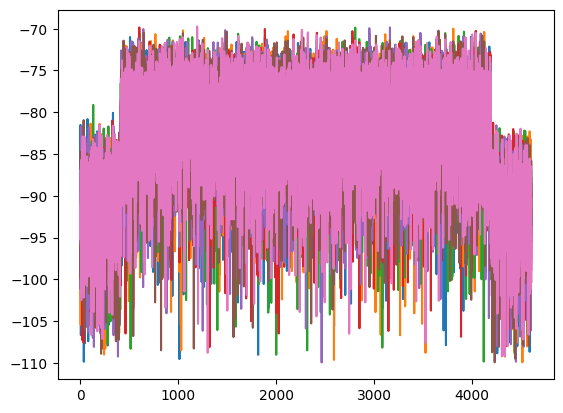

In [14]:
# simulation with noise
noise_floor_dBm = -180 # dBm
noisySig = TDS_perso.add_awgn(signalPathLoss, fs_Tx, noise_floor_dBm)

_, psd = TDS_perso.normalizeFFT(ifftshift(noisySig,  axes=0).T, fs_Tx)
plt.plot(psd.T)

True DOA : [-30.96375653   7.12501635]
estimation beam =  [-32]
estimation capon =  [-31]
estimation music =  [-31]


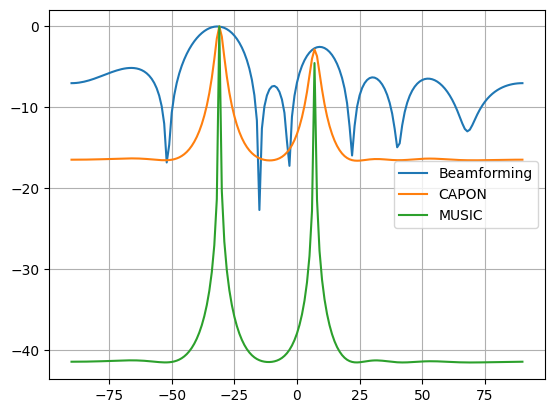

In [15]:
Rxx = np.dot(noisySig.T.conj(), noisySig)/Nech

# beamforming
beam = steerVect.conj()@Rxx@steerVect.T
beam = np.abs(np.sum(beam, axis=1))
beam = beam/np.max(beam) # normalisation

# CAPON
Rxx_inv = np.linalg.pinv(Rxx + 1e-16*np.eye(Rxx.shape[0]))
capon = np.zeros(len(thetaVect), dtype="complex")
for it in range(len(thetaVect)):
    capon[it] = 1/(steerVect[it,:].conj()@Rxx_inv@steerVect[it,:].T)
capon = np.abs(capon)
capon = capon/np.max(capon) # normalisation

# MUSIC
nsource = n_Tx
eigVal, eigVect = np.linalg.eig(Rxx)
idx = np.argsort(eigVal)[::-1]
eigVect = eigVect[:, idx]
EE = eigVect[:, nsource:]@eigVect[:, nsource:].T.conj()
music = np.zeros(len(thetaVect), dtype="complex")
for it in range(len(thetaVect)):
    music[it] = 1/(steerVect[it,:].conj()@EE@steerVect[it,:].T)
music = np.abs(music) # normalisation
music = music/np.max(music) # normalisation

# estimation doa
print("True DOA :", np.rad2deg(real_doa))

locBeam = np.where(beam==np.max(beam))
print("estimation beam = ", thetaVect[locBeam])

locCAPON = np.where(capon==np.max(capon))
print("estimation capon = ", thetaVect[locCAPON])

locMUSIC = np.where(music==np.max(music))
print("estimation music = ", thetaVect[locMUSIC])


plt.figure()
plt.plot(thetaVect, 10*np.log10(beam), label="Beamforming")
plt.plot(thetaVect, 10*np.log10(capon), label="CAPON")
plt.plot(thetaVect, 10*np.log10(music), label="MUSIC")

plt.grid()
plt.legend()


In [16]:
def beamforming_1D(Rxx, steeringVect):
    """
    Beamforming 1D
    input: 
    - Rxx(ndarray): covariance matrix of the signal 
    - steering Vector(array)
    output:
    - beamNorm(array): normalized beamforming estimation
    - beam(array):  beamforming estimation
    """
    beam = steerVect.conj()@Rxx@steerVect.T
    beam = np.abs(np.sum(beam, axis=1))
    beamNorm = beam/np.max(beam) # normalisation
    return beamNorm, beam

def CAPON_beamformer_1D(Rxx, steeringVect):
    """
    Capon beamformer 1D
    input: 
    - Rxx(ndarray): covariance matrix of the signal 
    - steering Vector(array)
    output:
    - caponNorm(array): normalized Capon beamformer estimation
    - capon(array):  Capon beamformer estimation
    """
    Rxx_inv = np.linalg.pinv(Rxx + 1e-16*np.eye(Rxx.shape[0]))
    capon = np.zeros(len(steeringVect), dtype="complex")
    for it in range(len(steeringVect)):
        capon[it] = 1/(steerVect[it,:].conj()@Rxx_inv@steerVect[it,:].T)
    capon = np.abs(capon)
    caponNorm = capon/np.max(capon) # normalisation
    return caponNorm, capon

def MUSIC_beamformer_1D(Rxx, steeringVect, nsource):
    """
    MUSIC beamformer 1D
    input: 
    - Rxx(ndarray): covariance matrix of the signal 
    - steering Vector(array)
    - nsource(int): number of source
    output:
    - musicNorm(array): normalized MUSIC beamformer estimation
    - music(array):  MUSIC beamformer estimation
    """
    eigVal, eigVect = np.linalg.eig(Rxx)
    idx = np.argsort(eigVal)[::-1]
    eigVect = eigVect[:, idx]
    EE = eigVect[:, nsource:]@eigVect[:, nsource:].T.conj()
    music = np.zeros(len(thetaVect), dtype="complex")
    for it in range(len(thetaVect)):
        music[it] = 1/(steerVect[it,:].conj()@EE@steerVect[it,:].T)
    music = np.abs(music) # normalisation
    musicNorm = music/np.max(music) # normalisation
    return musicNorm, music

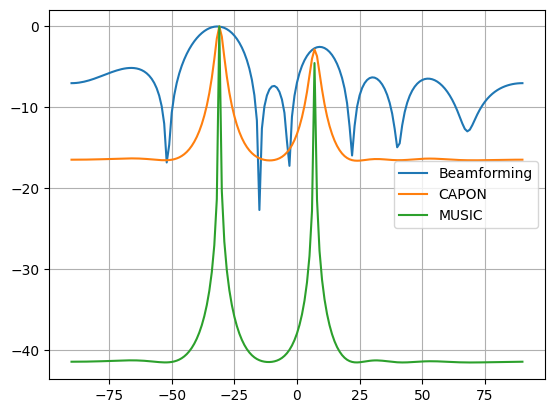

In [17]:
beamNorm, _ = beamforming_1D(Rxx, steerVect)
caponNorm, _ = CAPON_beamformer_1D(Rxx, steerVect)
musicNorm, _ = MUSIC_beamformer_1D(Rxx, steerVect, nsource)

plt.figure()
plt.plot(thetaVect, 10*np.log10(beamNorm), label="Beamforming")
plt.plot(thetaVect, 10*np.log10(caponNorm), label="CAPON")
plt.plot(thetaVect, 10*np.log10(musicNorm), label="MUSIC")

plt.grid()
plt.legend()

In [18]:
# Estimateur ESPRIT

K = nsource
M = N_ant
d = dx/lambdaVal
# --------------------------
# Décomposition en valeurs propres
# --------------------------
eigvals, eigvecs = np.linalg.eig(Rxx)
idx = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, idx]

# Sous-espace signal
Es = eigvecs[:, :K]

# --------------------------
# Formation des sous-matrices pour ESPRIT
# --------------------------
Es1 = Es[:-1, :]
Es2 = Es[1:, :]

# --------------------------
# Estimation de la matrice de rotation
# --------------------------
Psi = np.linalg.pinv(Es1) @ Es2
eigvals_psi = np.linalg.eigvals(Psi)

# Estimation des angles
theta_est = -np.arcsin(np.angle(eigvals_psi)/(2*np.pi*d))
theta_est_deg = np.rad2deg(theta_est)

print("Angles estimés par ESPRIT :", np.real(theta_est_deg))
print("True DOA :", np.rad2deg(real_doa))


Angles estimés par ESPRIT : [-30.9535818    7.09670044]
True DOA : [-30.96375653   7.12501635]


In [21]:
# Root MUSIC 
K = nsource
eigvals, eigvecs = eig(Rxx)
idx = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, idx]
En = eigvecs[:, K:]  # sous-espace bruit


En_flip = np.flipud(En)
poly = np.conj(En[0, :])
roots = np.roots(poly)
print(d)
roots_on_unit_circle = roots[np.argmin(np.abs(roots)-1)]
theta_root = -np.arcsin(np.angle(roots_on_unit_circle)/(2*np.pi*d))
theta_root_deg = np.degrees(theta_root)

print("Angles estimés par ROOT-MUSIC :", np.real(theta_root_deg))
print("True DOA :", np.rad2deg(real_doa))


0.5
Angles estimés par ROOT-MUSIC : -19.156167681622655
True DOA : [-30.96375653   7.12501635]
